## Load packages

In [ ]:
from codecarbon import EmissionsTracker
tracker = EmissionsTracker(project_name="federated_learning_model_emissions1")
tracker.start()

c:\Users\Chigozie\miniconda3\envs\zindi\Lib\site-packages\codecarbon\core\gpu.py:4: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
[codecarbon WARNING @ 21:16:57] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 21:16:57] [setup] RAM Tracking...
[codecarbon INFO @ 21:16:57] [setup] CPU Tracking...
[codecarbon WARNING @ 21:17:06] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:17:06] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-4600U CPU @ 2.10GHz
[codecarbon WARNING @ 21:17:06] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:17:06] [setup] GPU Tracking...
[codecarbon INFO @ 21:17:06] No GPU found.

In [2]:
import numpy as np
import pandas as pd
import torch, random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os, re, gc
from glob import glob
from sklearn.model_selection import train_test_split, KFold
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from typing import Literal, Optional
from torch.utils.data import Dataset, DataLoader
import copy, logging
import joblib
import matplotlib.pyplot as plt
from modelling_utils import KmerAutoEncoder, KmerClassifier, AutoEncoderScaler, normalise_counts, LogisticRegression
from modelling_utils import load_encoder_model, test_loop, train_loop, print_info, set_seed
from fl_utils import Client, Server, PreprocessClientData, create_dataloader, get_embeddings, ClientDataset
import visual_utils
import time

In [3]:
start = time.time()
set_seed(42)

In [4]:
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger(__name__)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

Using cpu


## Helper functions

In [5]:
def load_datasets(base_dir): 
    """
    Loads dataset

    :param base_dir: Base directory where client data are stored
    :returns pd.DataFrame. All dataset in folder path (in kmers x sampleIDs)
    """
    try:
        logger.info(f'Loading Dataset from {base_dir} directory')
        files = glob(f'{base_dir}/**/*.parquet')
        all_data = []
        if files:
            clients = list(map(lambda x: re.search('Mouth|Nasal|Stool|Skin', x, flags=re.IGNORECASE), files))
            clients = [client.group() if client else None for client in clients]
        
        for _, file in enumerate(files):
            all_data.append(pd.read_parquet(file))
    except Exception as err:
        logger.exception(f'Error loading datasets.\n{err}')
    all_data = pd.concat(all_data, axis=1)
    logger.info('Datasets loaded')
    return all_data


In [6]:
class GlobalModel:
    def __init__(self, model_fn):
        self.model_fn = model_fn
        self.model = None
        self.scaler = None
    
    def fit(self, X):
        if self.model_fn.global_scaler:
            self.scaler = self.model_fn.global_scaler
        self.scaler.fit(X)
        self.model = self.model_fn.global_model.to(device)
        return self
    
    def transform(self, X):
        if self.scaler:
            X = self.scaler.transform(X)
        X = create_dataloader(X, batch_size=128, shuffle=False)
        return X
    
    def predict_proba(self, X):
        if self.model is None:
            self.fit(X)
        X_loader = self.transform(X)
        
        self.model.eval()
        probs = []
        with torch.no_grad():
            for inputs, _ in X_loader:
                outputs = self.model(inputs.to(device))
                prob = F.softmax(outputs, dim=1)
                probs.append(prob)
        probs = torch.cat(probs).cpu().numpy()
        return probs
    
    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)


### Loading datasets

In [ ]:
train_labels = pd.read_csv('../data/Train.csv')
subjects = train_labels.groupby('SubjectID').size().sort_values(ascending=False).index
subject_ids = {k:j for k, j in zip(train_labels.filename.str.replace('.mgb', '').str.strip(), train_labels.SubjectID)}
subject_info = train_labels[['filename', 'SampleType', 'SubjectID']]
subject_info.loc[:, 'filename'] = subject_info.loc[:, 'filename'].str.replace('.mgb', '').str.strip()
subject_info =  subject_info.rename(columns={'filename': 'ID', 'SampleType': 'label', 'SubjectID': 'subject_id'}).set_index('ID')

__Loading client data__

In [ ]:
client_data = load_datasets('../data/fl_data/')
print()
client_data.shape


# transpose to ID vs kmer
client_data = client_data.T

Loading Dataset from data/fl_data/ directory
[codecarbon INFO @ 21:17:21] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:17:21] Delta energy consumed for CPU with constant : 0.000125 kWh, power : 30.0 W
[codecarbon INFO @ 21:17:21] Energy consumed for All CPU : 0.000125 kWh
[codecarbon INFO @ 21:17:21] 0.000167 kWh of electricity used since the beginning.
Datasets loaded


__Load client datasets and extract their embeddings__

In [ ]:
# autoencoder model
encoder_scaler = joblib.load('../data/models/encoder_scaler.pkl')
encoder_model = load_encoder_model('../data/models/clr_std_latent64_epoch112_model_k8.pth')


## Data Preprocessing

Prepare client data by 

- Splitting data into 4 clients based on subject ID, where a subject is assigned to only one client to maintain privacy

- Extracting and scaling autoencoder embeddings for modelling

In [10]:
# prepare Client Data and extract their emebddings
prep = PreprocessClientData(encoder_scaler, client_data, subject_info)
client_embeddings = prep.preprocess_client_data(encoder_model, label_id='label', unique_id='subject_id', 
                                                num_clients=4, random_state=42, test_fraction=0.15)

Data Preprocessing
Splitting data into 4 clients...
Normalising and scaling kmer counts...
[codecarbon INFO @ 21:17:38] Energy consumed for RAM : 0.000085 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:17:38] Delta energy consumed for CPU with constant : 0.000137 kWh, power : 30.0 W
[codecarbon INFO @ 21:17:38] Energy consumed for All CPU : 0.000262 kWh
[codecarbon INFO @ 21:17:38] 0.000347 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:17:55] Energy consumed for RAM : 0.000123 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:17:55] Delta energy consumed for CPU with constant : 0.000139 kWh, power : 30.0 W
[codecarbon INFO @ 21:17:55] Energy consumed for All CPU : 0.000401 kWh
[codecarbon INFO @ 21:17:55] 0.000524 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:18:07] Energy consumed for RAM : 0.000156 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:18:07] Delta energy consumed for CPU with constant : 0.000100 kWh, power : 30.0 W
[codecarbon INFO @ 21:1

In [11]:
# get input shape
input_dim = client_embeddings['0'][0].shape[1]
num_classes = 4
input_dim

64

## Modelling

- Provide configuration setting for both client and server (where the global model's weights are updated via federated averaging)

__Configuration settings for both client and server__

In [12]:
# configuration setings for client and server (global model)
class ClientConfig:
    config = {
        'local_epochs' : 5, #number of local training rounds
        'loss_fn' : nn.CrossEntropyLoss(),
        'optimiser' : optim.RMSprop, # optim.AdamW,
        'lr' : 5e-4, 
        'weight_decay' : 0,
        'random_state' : 42,
        'n_epoch_print' : 250,
        'verbose' : False,
        'validation_fraction': 0.15, # fraction for validation
        'batch_size' : 128,
        'shuffle' : True # shuffle during training
    }

class StrategyConfig:
    config = {
        'fit_fraction' : 1., # train using 100% of the clients
        'num_rounds' : 200, # number of training rounds to update global model's weights
        'fraction_evaluate': 1., # evaluate on test data of all clients
        'early_stopping': True,
        'patience' : 50, 
        'verbose' : True,
        'eval_metric' : 'loss',
        'random_state':42,
        'n_epoch_print': 20
    }

In [13]:
# Instantiate client and server class
client_config = ClientConfig.config
strategy_config = StrategyConfig.config

__Instantiating global model__

- Assigning clients with global model parameters and their respective client configuratons

In [14]:
# instantiate global model and clients
global_model = KmerClassifier(input_dim=64, num_classes=num_classes, layer_mult=3)

# instantiate clients models
clients = [Client(global_model, client_embeddings.get(key), config=client_config) for key in client_embeddings.keys()]

In [15]:
def server_fn(global_model, clients_models, strategy_config):
    """
    Server App
    
    :param global_model: Global model class
    :param client_models: Client models
    :param strategy_config: Confugration settings for server
    :returns: Server class object
    """
    server = Server(global_model, clients_models, strategy_config)
    config = server.check_server_config(server.strategy_config)
    server.train_rounds(**config)
    return server

In [16]:
# return for use
logger.info('Performing Federated Learning\n===============================')
fc_server = server_fn(global_model, clients, strategy_config)

Performing Federated Learning
Total Clients: 4
4 clients selected for training and 4 for evaluation

Training started in server
[codecarbon INFO @ 21:18:52] Energy consumed for RAM : 0.000281 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:18:52] Delta energy consumed for CPU with constant : 0.000125 kWh, power : 30.0 W
[codecarbon INFO @ 21:18:52] Energy consumed for All CPU : 0.000876 kWh
[codecarbon INFO @ 21:18:52] 0.001157 kWh of electricity used since the beginning.
Round 1
Client: Loss: 0.32651919311346, Accuracy: 0.9846547314578006
Server: Loss: 0.30546790787151884, Accuracy: 0.9820971867007673


+=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+ 



[codecarbon INFO @ 21:19:07] Energy consumed for RAM : 0.000322 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:19:07] Delta energy consumed for CPU with constant : 0.000125 kWh, power : 30.0 W
[codecarbon INFO @ 21:19:07] Energy consumed for All CPU : 0.001001 kWh
[codecarbon INFO @ 21:19:07] 0.001323 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:19:07] 0.004573 g.CO2eq/s mean an estimation of 144.2032209406938 kg.CO2eq/year
Round 20
Client: Loss: 0.10983425268414997, Accuracy: 0.9923273657289002
Server: Loss: 0.05931045395815663, Accuracy: 0.9948849104859335


+=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+ 



[codecarbon INFO @ 21:19:22] Energy consumed for RAM : 0.000364 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:19:22] Delta energy consumed for CPU with constant : 0.000125 kWh, power : 30.0 W
[codecarbon INFO @ 21:19:22] Energy consumed for All CPU : 0.001126 kWh
[codecarbon INFO @ 21:19:22] 0.001490 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:19:37] Energy consumed for RAM : 0.000406 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:19:37] Delta energy consumed for CPU with constant : 0.000125 kWh, power : 30.0 W
[codecarbon INFO @ 21:19:37] Energy consumed for All CPU : 0.001251 kWh
[codecarbon INFO @ 21:19:37] 0.001656 kWh of electricity used since the beginning.
Round 40
Client: Loss: 0.12801853275885006, Accuracy: 0.9923273657289002
Server: Loss: 0.06774550360835463, Accuracy: 0.9948849104859335


+=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+ 



[codecarbon INFO @ 21:19:52] Energy consumed for RAM : 0.000447 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:19:52] Delta energy consumed for CPU with constant : 0.000125 kWh, power : 30.0 W
[codecarbon INFO @ 21:19:52] Energy consumed for All CPU : 0.001376 kWh
[codecarbon INFO @ 21:19:52] 0.001823 kWh of electricity used since the beginning.

Val data: Best epoch: 5, Loss: 0.036372086216163425, Accuracy: 0.9846547314578005
Test Evaluation: Loss: 0.062258386459067845, Accuracy: 0.9954128440366973

Training Completed!


Early Stopping around round 55


In [17]:
# define global model
model = GlobalModel(fc_server) 

# get label IDs and names
lab_ids = clients[0].label_ids
lab_names = list(lab_ids.keys())

print(lab_ids, lab_names)

{'Mouth': 0, 'Nasal': 1, 'Skin': 2, 'Stool': 3} ['Mouth', 'Nasal', 'Skin', 'Stool']


Classification Report
Classification Evaluation Metrics
Saving Classification Performance Chart Report


              precision    recall  f1-score   support

       Mouth       0.99      0.99      0.99       101
       Nasal       1.00      1.00      1.00       114
        Skin       0.99      0.99      0.99       109
       Stool       1.00      1.00      1.00       112

    accuracy                           1.00       436
   macro avg       1.00      1.00      1.00       436
weighted avg       1.00      1.00      1.00       436


             Acc       AUC       Rec      Prec        AP        F1      Spec  \
scores  0.995413  0.999316  0.995231  0.995231  0.996434  0.995231  0.998489   

           LLoss  
scores  0.065678  




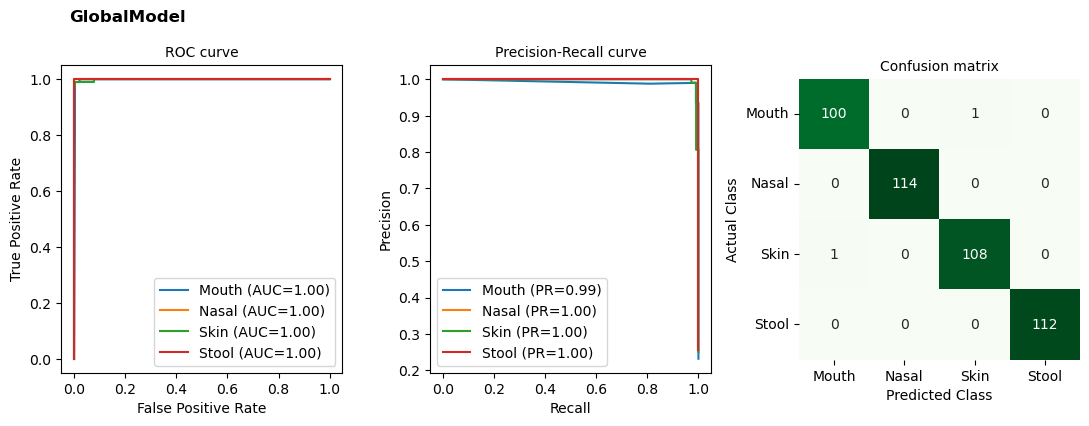

In [18]:
# Visualising global model's performance on the test data from all clients
if clients[0].test_data is not None:
    all_test = [(model.test_data, model.test_labels) for model in clients]
    X, y = zip(*all_test)
    X = np.vstack(X)
    y = np.concatenate(y)
    X.shape, y.shape
    y = list(map(lambda x: lab_ids.get(x), y))

    logger.info('Classification Report')
    visual_utils.print_classification_report(model, X, y, lab_names)
    print()

    logger.info('Classification Evaluation Metrics')
    print(visual_utils.classification_eval_metrics(model, X, y))
    print()


    logger.info('Saving Classification Performance Chart Report')
    visual_utils.classification_performance_chart_report(model, X, y, display_names=lab_names)
    plt.savefig('classification_performance_chart_report.png')
    print()

### Test predictions

In [ ]:
# Load test data
logger.info('Obtaining Test Predictions for submission\n')

test_data = pd.read_parquet('../data/test_8kmer.parquet')
test_data.shape
# transpose to samples x features
test_data = test_data.T

# get their sample IDs
test_idx = test_data.index.tolist()

Obtaining Test Predictions for submission



In [20]:
# prepare test data
def prepare_test(X, encoder_model, encoder_scaler):
    # normalise and scale using the encoder scaler to get embeddings
    norm_X = normalise_counts(X)
    test_scaled = encoder_scaler.transform(norm_X)
    test_embeddings = get_embeddings(encoder_model, test_scaled)
    return test_embeddings


def save_file(probs, ids, filename):
    cols = lab_names
    path = 'preds'
    os.makedirs(path, exist_ok=True)
    df = pd.DataFrame()
    df['ID'] = test_idx
    df[cols] = probs
    print(df)
    filepath = os.path.join(path, f'{filename}.csv')
    df.to_csv(filepath, index=False)

In [21]:
# get test embeddings
logger.info('Preparing test embeddings')
test_embs = prepare_test(test_data, encoder_model, encoder_scaler)

Preparing test embeddings
[codecarbon INFO @ 21:20:07] Energy consumed for RAM : 0.000489 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:20:07] Delta energy consumed for CPU with constant : 0.000128 kWh, power : 30.0 W
[codecarbon INFO @ 21:20:07] Energy consumed for All CPU : 0.001503 kWh
[codecarbon INFO @ 21:20:07] 0.001993 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:20:22] Energy consumed for RAM : 0.000530 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:20:22] Delta energy consumed for CPU with constant : 0.000123 kWh, power : 30.0 W
[codecarbon INFO @ 21:20:22] Energy consumed for All CPU : 0.001626 kWh
[codecarbon INFO @ 21:20:22] 0.002157 kWh of electricity used since the beginning.


In [22]:
# test probabilities
logger.info('Predicting test probabilities')
test_probs = model.predict_proba(test_embs)

Predicting test probabilities


In [ ]:
# save file
logger.info('Saving test predictions')
save_file(test_probs, test_idx, 'federated_learnin_preds1')

Saving test predictions


             ID         Mouth         Nasal          Skin         Stool
0     ID_UOIPKJ  1.636644e-10  4.030085e-11  1.401852e-10  1.000000e+00
1     ID_XHBQPF  1.000000e+00  9.167727e-10  1.355014e-08  1.387964e-10
2     ID_KYILXT  1.000000e+00  2.889384e-10  1.511909e-09  1.341857e-11
3     ID_UFGHMX  9.157342e-11  5.357030e-11  7.754159e-11  1.000000e+00
4     ID_URMZQG  2.300128e-10  1.000000e+00  7.064462e-10  1.307970e-11
...         ...           ...           ...           ...           ...
1063  ID_FUMEPV  2.482775e-10  1.000000e+00  1.413953e-09  4.931185e-11
1064  ID_RWUAEX  3.321902e-10  7.441771e-11  1.690682e-10  1.000000e+00
1065  ID_PLZYXW  9.988624e-01  3.988868e-07  1.137216e-03  4.477554e-08
1066  ID_TJNQXM  1.285495e-09  4.015491e-11  1.000000e+00  1.388832e-10
1067  ID_DSBIZA  6.201890e-11  2.929923e-11  4.657377e-11  1.000000e+00

[1068 rows x 5 columns]


In [24]:
# total time
end = time.time()
mins = (end - start)/60
logger.info(f'\nTotal Time taken : {mins:.4f} Mins')

tracker.stop()


Total Time taken : 3.0884 Mins
[codecarbon INFO @ 21:20:25] Energy consumed for RAM : 0.000539 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:20:25] Delta energy consumed for CPU with constant : 0.000026 kWh, power : 30.0 W
[codecarbon INFO @ 21:20:25] Energy consumed for All CPU : 0.001652 kWh
[codecarbon INFO @ 21:20:25] 0.002191 kWh of electricity used since the beginning.


0.0009128899947790731